In [ ]:
import pandas as pd

df = pd.read_csv('/content/crop_yield.csv')
display(df.head())

/tmp/ipython-input-3735655045.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/crop_yield.csv')


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122.0,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140.0,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106.0,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146.0,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110.0,7.248251


## Preprocess data

Clean the data by handling missing values, removing noise, and normalizing inputs. Split the data into training, validation, and testing sets.



Check for missing values in the DataFrame.



In [ ]:
display(df.isnull().sum())

# Drop rows with missing values in the target variable
df.dropna(subset=['Yield_tons_per_hectare'], inplace=True)

,0
Region,0
Soil_Type,0
Crop,0
Rainfall_mm,0
Temperature_Celsius,1
Fertilizer_Used,1
Irrigation_Used,1
Weather_Condition,1
Days_to_Harvest,1
Yield_tons_per_hectare,1


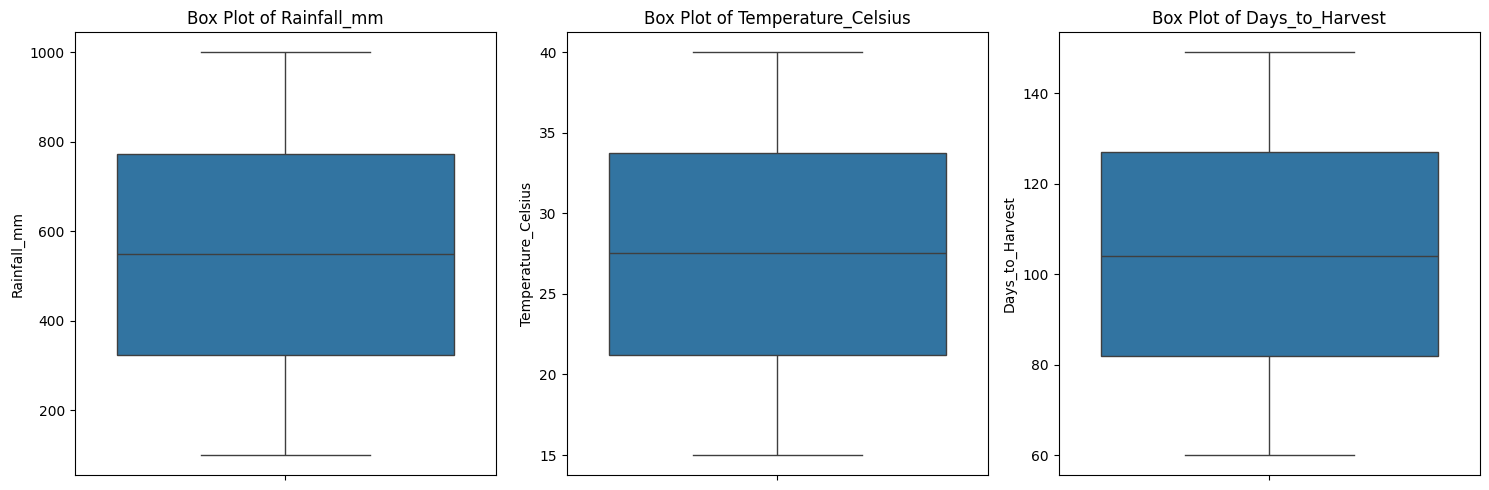

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, len(numerical_features), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

display(df.head())

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,1.339657,0.024650,False,True,Cloudy,0.676804,6.555816
1,South,Clay,Rice,1.707540,-1.312579,True,True,Rainy,1.369816,8.527341
2,North,Loam,Barley,-1.543032,0.317994,False,False,Sunny,0.060792,1.127443
3,North,Sandy,Soybean,1.685193,-1.504064,False,True,Rainy,1.600821,6.517573
4,South,Silt,Wheat,0.698151,0.571096,True,True,Cloudy,0.214795,7.248251


Split the processed data into training, validation, and testing sets.



In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Yield_tons_per_hectare', axis=1)
y = df['Yield_tons_per_hectare']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

display(f'Shape of X_train: {X_train.shape}')
display(f'Shape of X_val: {X_val.shape}')
display(f'Shape of X_test: {X_test.shape}')
display(f'Shape of y_train: {y_train.shape}')
display(f'Shape of y_val: {y_val.shape}')
display(f'Shape of y_test: {y_test.shape}')

'Shape of X_train: (60618, 9)'

'Shape of X_val: (20206, 9)'

'Shape of X_test: (20207, 9)'

'Shape of y_train: (60618,)'

'Shape of y_val: (20206,)'

'Shape of y_test: (20207,)'

## Feature engineering


Select relevant features and prepare the data in a time-series format.


Apply one-hot encoding to the categorical features in the training, validation, and testing sets and concatenate with numerical features.



In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['Region', 'Soil_Type', 'Crop', 'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_categorical = encoder.fit_transform(X_train[categorical_features])
X_val_categorical = encoder.transform(X_val[categorical_features])
X_test_categorical = encoder.transform(X_test[categorical_features])

numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

X_train_processed = pd.concat([pd.DataFrame(X_train_categorical, index=X_train.index), X_train[numerical_features]], axis=1)
X_val_processed = pd.concat([pd.DataFrame(X_val_categorical, index=X_val.index), X_val[numerical_features]], axis=1)
X_test_processed = pd.concat([pd.DataFrame(X_test_categorical, index=X_test.index), X_test[numerical_features]], axis=1)

display(f'Shape of X_train_processed: {X_train_processed.shape}')
display(f'Shape of X_val_processed: {X_val_processed.shape}')
display(f'Shape of X_test_processed: {X_test_processed.shape}')

'Shape of X_train_processed: (60618, 26)'

'Shape of X_val_processed: (20206, 26)'

'Shape of X_test_processed: (20207, 26)'


Reshape the processed data into a time-series format suitable for an RNN model, treating each data point as a single time step.



In [ ]:
import numpy as np

X_train_processed = np.reshape(X_train_processed, (X_train_processed.shape[0], 1, X_train_processed.shape[1]))
X_val_processed = np.reshape(X_val_processed, (X_val_processed.shape[0], 1, X_val_processed.shape[1]))
X_test_processed = np.reshape(X_test_processed, (X_test_processed.shape[0], 1, X_test_processed.shape[1]))

display(f'Shape of X_train_processed after reshaping: {X_train_processed.shape}')
display(f'Shape of X_val_processed after reshaping: {X_val_processed.shape}')
display(f'Shape of X_test_processed after reshaping: {X_test_processed.shape}')

'Shape of X_train_processed after reshaping: (60618, 1, 26)'

'Shape of X_val_processed after reshaping: (20206, 1, 26)'

'Shape of X_test_processed after reshaping: (20207, 1, 26)'

## Model

A Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that is designed to handle sequential data. GRUs are particularly effective at capturing dependencies in sequences, making them suitable for time series analysis and other tasks where the order of data points matters. They address the vanishing gradient problem, a common issue in traditional RNNs where gradients become very small during backpropagation through many time steps, hindering the network's ability to learn long-term dependencies.

Key Components of a GRU:
1. Reset Gate: This gate determines how much of the previous hidden state is relevant to the current hidden state. A value close to zero means the previous state is mostly ignored, allowing the model to 'forget' irrelevant past information.
2. Update Gate: This gate determines how much of the previous hidden state to carry over to the current hidden state and how much of the new candidate hidden state to incorporate. It helps the model to remember relevant past information over long sequences.
These gates use sigmoid activation functions to output values between 0 and 1, acting as filters for the information flowing through the network.

Suitability for Crop Yield Prediction:
Crop yield prediction can involve time-series data (e.g., rainfall, temperature over time). While our current data is structured with a single time step per observation, in a more complex scenario with historical weather data, soil conditions, and other time-dependent factors, a GRU's ability to process sequential information and capture dependencies over time would be highly beneficial for predicting future yields.


## Build GRU Model

Define the architecture of the GRU model using Keras.


Based on the plan, the next step is to define the architecture of the GRU model. This involves importing necessary libraries, creating a Sequential model, adding GRU and Dense layers, and printing the model summary.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

model = Sequential()
model.add(GRU(50, input_shape=(X_train_processed.shape[1], X_train_processed.shape[2]), return_sequences=False))
model.add(Dense(1))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,751 (45.90 KB)

 Trainable params: 11,751 (45.90 KB)

 Non-trainable params: 0 (0.00 B)

## Compile GRU Model

Configure the model for training by specifying the optimizer, loss function, and metrics.

Configure the GRU model for training with the Adam optimizer, mean squared error loss, and mean absolute error metric.

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

## Train GRU Model

Train the compiled GRU model using the training data and validate on the validation set.

In [ ]:
history = model.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_data=(X_val_processed, y_val))

Epoch 1/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.5701 - mean_absolute_error: 0.9530 - val_loss: 0.2709 - val_mean_absolute_error: 0.4157
Epoch 2/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.2541 - mean_absolute_error: 0.4030 - val_loss: 0.2636 - val_mean_absolute_error: 0.4095
Epoch 3/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.2543 - mean_absolute_error: 0.4029 - val_loss: 0.2623 - val_mean_absolute_error: 0.4087
Epoch 4/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2545 - mean_absolute_error: 0.4033 - val_loss: 0.2592 - val_mean_absolute_error: 0.4058
Epoch 5/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2542 - mean_absolute_error: 0.4028 - val_loss: 0.2645 - val_mean_absolute_error: 0.4099
Epoch 6/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2560 - mean_absolute_error: 0.4046 - val_loss: 0.2598 - val_mean_absolute_error: 0.4067
Epoch 7/50
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2556 - mean_absolu

## Evaluate GRU Model

Evaluate the trained model's performance on the test set using metrics such as R², RMSE, and MAE.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict(X_test_processed)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

display(f'R² Score: {r2}')
display(f'RMSE: {rmse}')
display(f'MAE: {mae}')

632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


'R² Score: 0.9131787620900434'

'RMSE: 0.501753322307724'

'MAE: 0.4004672181469835'

## Visualize Results


Generate visualizations to show the predicted vs. actual yields and error distribution.

Visualize the predicted versus actual crop yields and the distribution of prediction errors to assess the model's performance visually.

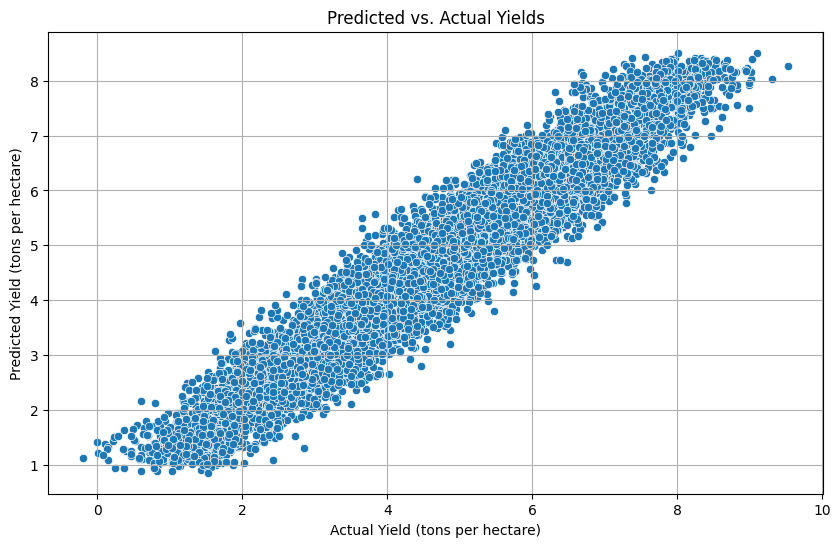

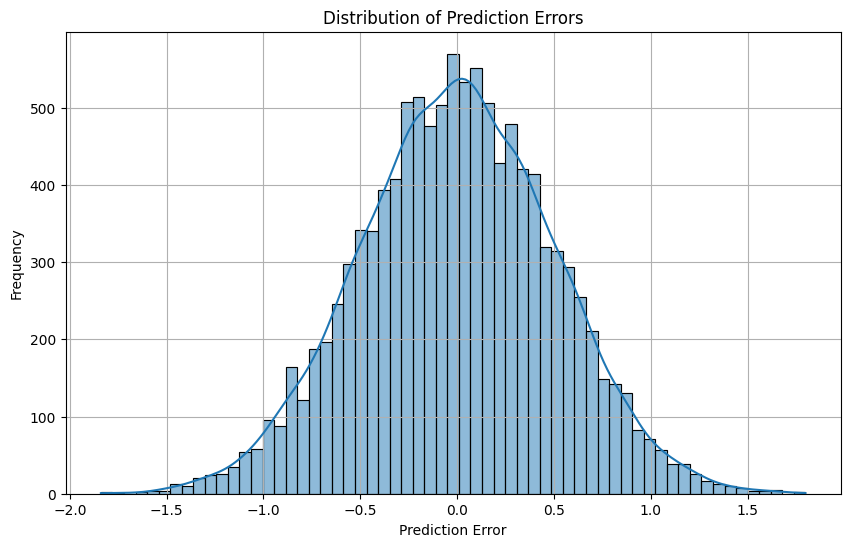

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Predicted vs. Actual Yields
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten())
plt.xlabel('Actual Yield (tons per hectare)')
plt.ylabel('Predicted Yield (tons per hectare)')
plt.title('Predicted vs. Actual Yields')
plt.grid(True)
plt.show()

# Histogram of Prediction Errors
errors = y_test.values.flatten() - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

First, let's save the trained model to a file. This allows you to reuse the model later without re-training.

In [ ]:
import tensorflow as tf

# Save the model
model_save_path = 'gru_crop_yield_model.keras'
model.save(model_save_path)
display(f'Model saved to {model_save_path}')

'Model saved to gru_crop_yield_model.keras'

Now, let's load the model back. You would typically do this in a new session or application where you want to use the trained model for predictions.